In [191]:
# General imports
import pathlib
import sys
import pickle
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import itertools
from sklearn import preprocessing
import random

In [192]:
# Import topicmodeler utilities
sys.path.append('..')
from src.tmWrapper.tm_wrapper import TMWrapper
from src.topicmodeler.src.topicmodeling.manageModels import TMmodel

In [193]:
oa_tpc = 25
pastat_tpc = 25
cordis_tpc = 26
oa_path = pathlib.Path(f"/export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/WP6models_old/TMmodels/OA_Kwds3_AI_{oa_tpc}tpc")
pastat_path = pathlib.Path(f"/export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/WP6models_old/TMmodels/PATSTAT_Kwds3_AI_{pastat_tpc}tpc")
cordis_path = pathlib.Path(f"/export/usuarios_ml4ds/jarenas/github/IntelComp/ITMT/topicmodeler/WP6models_old/TMmodels/Cordis_Kwds3_AI_{cordis_tpc}tpc")

In [194]:
# Create TMmodel objects
tm_oa = TMmodel(oa_path.joinpath("TMmodel"))
tm_pastat = TMmodel(pastat_path.joinpath("TMmodel"))
tm_cordis = TMmodel(cordis_path.joinpath("TMmodel"))


def get_tm_model_df(tm_model:TMmodel) -> pd.DataFrame:
    """
    Get model information as dataframe, where each row is a topic
    
    Parameters
    ----------
    tm_model: TMmodel object
    
    Returns
    -------
    df: pd.DataFrame
        Dataframe with tpc_id, betas, alphas, tpc_descriptions, tpc_labels, vocab (all model vocab, to be used later on)
    vocab_w2id: Dict
        Vocabulary dictionaries with the words as key
    """
    df, vocab_id2w, vocab, vocab_w2id = tm_model.to_dataframe()
    df = df.apply(pd.Series.explode)
    df.reset_index(drop=True)
    df["tpc_id"] = [i for i in range(len(df))]
    df = df[["tpc_id", "betas", "alphas", "tpc_descriptions", "tpc_labels"]]
    
    # Get words in each topic
    def get_tp_words(
        vector: np.array,
        vocab_id2w: dict,
    ) -> str:
        return ", ".join([vocab_id2w[str(idx)] for idx, val in enumerate(vector) if val > 0])

    df["vocab"] = df["betas"].apply(
        lambda x: get_tp_words(x, vocab_id2w))
    
    return df, vocab_w2id

df_oa, vocab_w2id_oa = get_tm_model_df(tm_oa)
df_pastat, vocab_w2id_pastat = get_tm_model_df(tm_pastat)
df_cordis, vocab_w2id_cordis = get_tm_model_df(tm_cordis)

INFO:TMmodel:-- -- -- Topic model object (TMmodel) successfully created
INFO:TMmodel:-- -- -- Topic model object (TMmodel) successfully created
INFO:TMmodel:-- -- -- Topic model object (TMmodel) successfully created


In [195]:
def get_common_vocab(df1,df2):
    return [word for word in df1.iloc[0].vocab.split(", ") if word in df2.iloc[0].vocab.split(", ")]

common_vocab_oa_pastat = get_common_vocab(df_oa,df_pastat)
common_vocab_pastat_cordis = get_common_vocab(df_pastat,df_cordis)

### THR

In [411]:
#def get_common_betas(vector, vocab_w2id, common_vocab):
#    return np.array([vector[int(vocab_w2id[word])] for word in common_vocab])

def get_common_betas(vector, vocab_w2id, common_vocab, thr=8e-05):
    return np.array([vector[int(vocab_w2id[word])] if vector[int(vocab_w2id[word])] > thr else 0 for word in common_vocab])

# TODO: Añadir umbral
# TODO2: Retener solamente las palabras que te dan el 90 % de cada tópico

thr_ = 0.020#0.025
df_oa["betas_common_pastat"] =  df_oa["betas"].apply(lambda x: get_common_betas(x, vocab_w2id_oa, common_vocab_oa_pastat, thr=thr_))
df_pastat["betas_common_oa"] = df_pastat["betas"].apply(lambda x: get_common_betas(x, vocab_w2id_pastat, common_vocab_oa_pastat, thr=thr_))
df_pastat["betas_common_cordis"] = df_pastat["betas"].apply(lambda x: get_common_betas(x, vocab_w2id_pastat, common_vocab_pastat_cordis, thr=thr_))
df_cordis["betas_common_pastat"] = df_cordis["betas"].apply(lambda x: get_common_betas(x, vocab_w2id_cordis, common_vocab_pastat_cordis, thr=thr_))

In [401]:
#df_oa['tpc_labels'] = df_oa['tpc_labels'].str.replace('and', 'and\n')
#df_pastat['tpc_labels'] = df_pastat['tpc_labels'].str.replace('and', 'and\n')
#df_cordis['tpc_labels'] = df_cordis['tpc_labels'].str.replace('and', 'and\n')

In [412]:
np.percentile(np.stack(df_oa.betas_common_pastat.to_numpy()), 99.9)

0.0

In [413]:
np.stack(df_oa.betas_common_pastat.to_numpy()).shape
np.stack(df_pastat.betas_common_oa.to_numpy()).shape
np.stack(df_pastat.betas_common_cordis.to_numpy()).shape
np.stack(df_cordis.betas_common_pastat.to_numpy()).shape

(26, 967)

In [414]:
def sim_word_comp(
    betas1: np.array,
    betas2: np.array,
    thr: float = 1e-3):
    # TODO: Calcular 100 * log
    return np.sqrt(betas1).dot(np.sqrt(betas2).T)
    #return 100 * np.log(np.sqrt(betas1).dot(np.sqrt(betas2).T))

In [415]:
def getRandRGB():
    randomRGB = ()
    for i in range(3):
        randomRGB = randomRGB + (random.randint(0,255),)
    randomRGB = randomRGB + (0.5,)
    randomRGB = f"rgba{randomRGB}"
    return(randomRGB)

In [416]:
sims = sim_word_comp(np.stack(df_oa.betas_common_pastat.to_numpy()),np.stack(df_pastat.betas_common_oa.to_numpy()))
sims2 = sim_word_comp(np.stack(df_pastat.betas_common_cordis.to_numpy()),np.stack(df_cordis.betas_common_pastat.to_numpy()))

In [243]:
a = [el for el in range(oa_tpc)]
b = [el for el in range(pastat_tpc)]
combinations = list(itertools.product(a, b))

c = [el for el in range(pastat_tpc)]
d = [el for el in range(cordis_tpc)]
combinations2 = list(itertools.product(c, d))

df_f = pd.DataFrame(
    {"source": [i for i,_ in combinations],
     "target": [j+oa_tpc for _,j in combinations],
     "value": [sims[i,j] for i,j in combinations],
    }
)

df_f2 = pd.DataFrame(
    {"source": [i+oa_tpc for i,_ in combinations2],
     "target": [j+(oa_tpc+pastat_tpc) for _,j in combinations2],
     "value": [sims2[i,j] for i,j in combinations2],
    }
)   

df_f_labels = pd.DataFrame(
    {
        "id": df_f.source.unique().tolist() + df_f.target.unique().tolist(),
        "labels": df_oa.tpc_labels.values.tolist() + df_pastat.tpc_labels.values.tolist(),
        "hover":  df_oa.tpc_descriptions.values.tolist() + df_pastat.tpc_descriptions.values.tolist(),
    }
)
df_f_labels["color"] = [getRandRGB() for el in range(len(df_f_labels))]

df_f_labels2 = pd.DataFrame(
    {
        "id": df_f2.target.unique().tolist(),
        "labels": df_cordis.tpc_labels.values.tolist(),
        "hover": df_cordis.tpc_descriptions.values.tolist(),
    }
)
df_f_labels2["color"] = [getRandRGB() for el in range(len(df_f_labels2))]

def get_color(
    row,
    df:pd.DataFrame
) -> str:
    return df.iloc[row].color


#df_f = df_f[df_f.value>0.57]
df_f["value_norm"] = (df_f["value"] - df_f["value"].min()) / (df_f["value"].max() - df_f["value"].min())  
df_f["value_norm"] = [int(el *100) for el in df_f.value_norm.values.tolist()]

df_f2["value_norm"] = (df_f2["value"] - df_f2["value"].min()) / (df_f2["value"].max() - df_f2["value"].min())  
df_f2["value_norm"] = [int(el *100) for el in df_f2.value_norm.values.tolist()]


df_f = pd.concat([df_f,df_f2])
df_f_labels = pd.concat([df_f_labels,df_f_labels2])
df_f["Link Color"] = df_f["source"].apply(lambda x: get_color(x, df_f_labels))

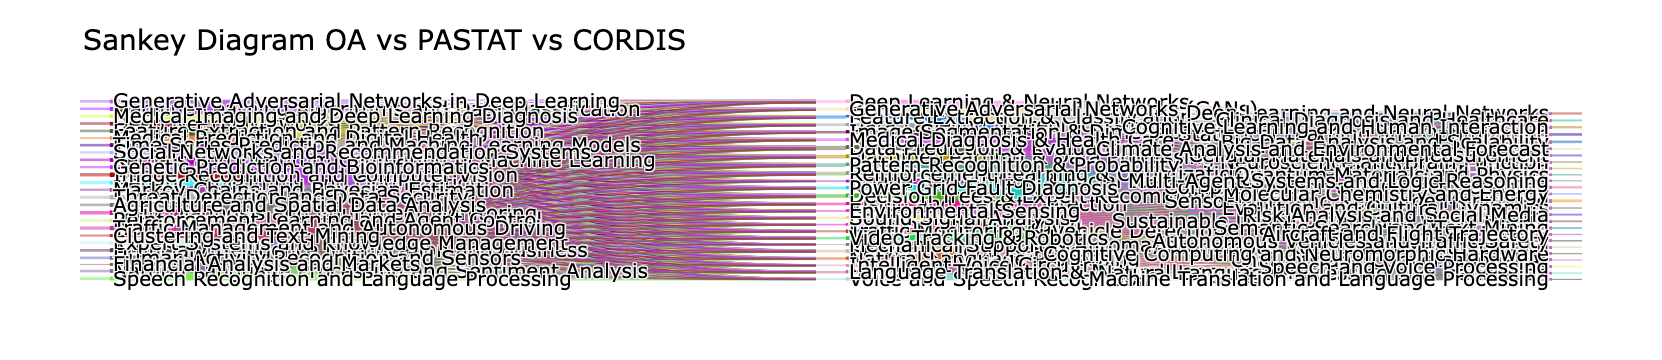

In [435]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[go.Sankey(
        type='sankey',
        domain = dict(
            x =  [0,1],
            y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
        pad = 10,
        thickness = 30,
        line = dict(
            color = "white",
            width = 0
        ),
        label = df_f_labels["labels"].values.tolist(),
        color = df_f_labels["color"].values.tolist(),
        customdata = df_f_labels["hover"].values.tolist(),
        hovertemplate='%{customdata}',  
        ),
        link = dict(
          arrowlen=15,
          source = df_f["source"].values.tolist(),
          target = df_f["target"].values.tolist(),
          value = df_f["value_norm"].values.tolist(),
          color = df_f['Link Color'].dropna(axis=0, how='any'),
      ))],
    layout = dict(
        title = "Sankey Diagram OA vs PASTAT vs CORDIS",
        height = 5000,#1000
        font = dict(
            size = 20,
            color='black'))
)

fig.show()

### Threshold is the avg

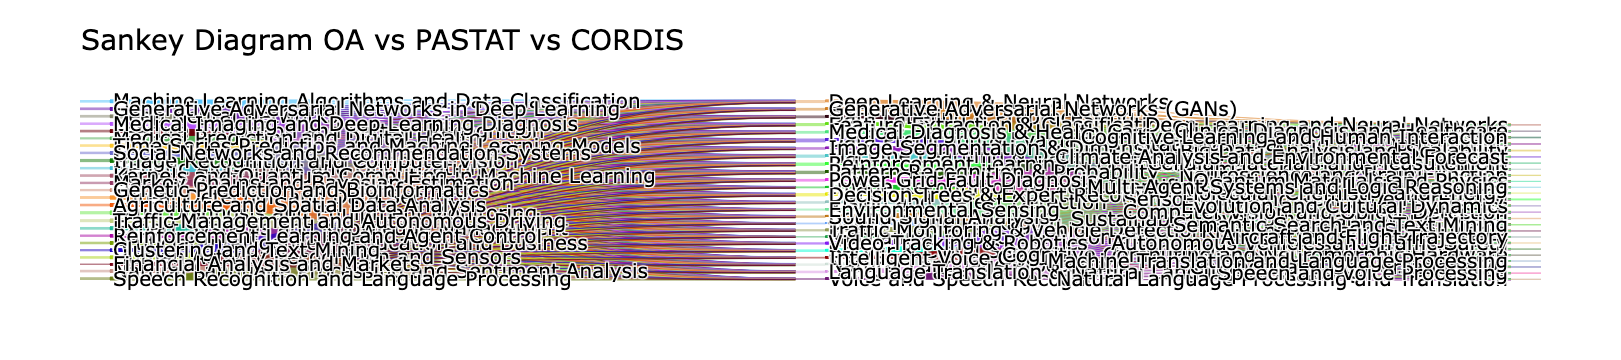

In [659]:
a = [el for el in range(oa_tpc)]
b = [el for el in range(pastat_tpc)]
combinations = list(itertools.product(a, b))

c = [el for el in range(pastat_tpc)]
d = [el for el in range(cordis_tpc)]
combinations2 = list(itertools.product(c, d))

df_f = pd.DataFrame(
    {"source": [i for i,_ in combinations],
     "target": [j+oa_tpc for _,j in combinations],
     "value": [sims[i,j] for i,j in combinations],
    }
)

df_f2 = pd.DataFrame(
    {"source": [i+oa_tpc for i,_ in combinations2],
     "target": [j+(oa_tpc+pastat_tpc) for _,j in combinations2],
     "value": [sims2[i,j] for i,j in combinations2],
    }
)   

df_f_labels = pd.DataFrame(
    {
        "id": df_f.source.unique().tolist() + df_f.target.unique().tolist(),
        "labels": df_oa.tpc_labels.values.tolist() + df_pastat.tpc_labels.values.tolist(),
        "hover":  df_oa.tpc_descriptions.values.tolist() + df_pastat.tpc_descriptions.values.tolist(),
    }
)
df_f_labels["color"] = [getRandRGB() for el in range(len(df_f_labels))]

df_f_labels2 = pd.DataFrame(
    {
        "id": df_f2.target.unique().tolist(),
        "labels": df_cordis.tpc_labels.values.tolist(),
        "hover": df_cordis.tpc_descriptions.values.tolist(),
    }
)
df_f_labels2["color"] = [getRandRGB() for el in range(len(df_f_labels2))]

def get_color(
    row,
    df:pd.DataFrame
) -> str:
    return df.iloc[row].color


df_f = pd.concat([df_f,df_f2])
df_f_labels = pd.concat([df_f_labels,df_f_labels2])
df_f["Link Color"] = df_f["source"].apply(lambda x: get_color(x, df_f_labels))

import plotly.graph_objects as go

fig = go.Figure(
    data=[go.Sankey(
        type='sankey',
        domain = dict(
            x =  [0,1],
            y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
        pad = 10,
        thickness = 30,
        line = dict(
            color = "white",
            width = 0
        ),
        label = df_f_labels["labels"].values.tolist(),
        color = df_f_labels["color"].values.tolist(),
        customdata = df_f_labels["hover"].values.tolist(),
        hovertemplate='%{customdata}',  
        ),
        link = dict(
          arrowlen=15,
          source = df_f["source"].values.tolist(),
          target = df_f["target"].values.tolist(),
          value = df_f["value"].values.tolist(),
          color = df_f['Link Color'].dropna(axis=0, how='any'),
      ))],
    layout = dict(
        title = "Sankey Diagram OA vs PASTAT vs CORDIS",
        height = 5000,#1000
        font = dict(
            size = 20,
            color='black'))
)

fig.show()

### Threshold is the average + log

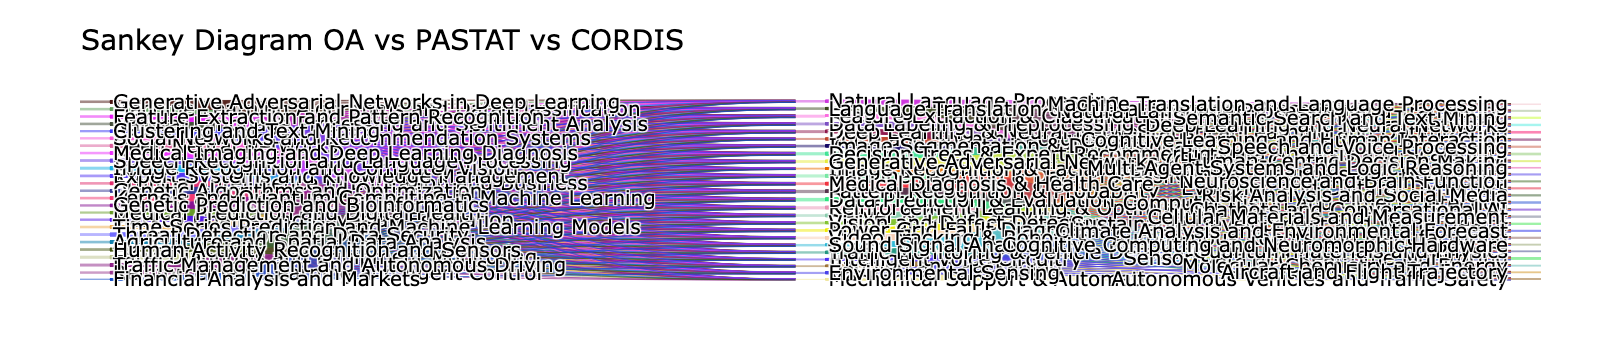

In [653]:
a = [el for el in range(oa_tpc)]
b = [el for el in range(pastat_tpc)]
combinations = list(itertools.product(a, b))

c = [el for el in range(pastat_tpc)]
d = [el for el in range(cordis_tpc)]
combinations2 = list(itertools.product(c, d))

df_f = pd.DataFrame(
    {"source": [i for i,_ in combinations],
     "target": [j+oa_tpc for _,j in combinations],
     "value": [sims[i,j] for i,j in combinations],
    }
)

df_f2 = pd.DataFrame(
    {"source": [i+oa_tpc for i,_ in combinations2],
     "target": [j+(oa_tpc+pastat_tpc) for _,j in combinations2],
     "value": [sims2[i,j] for i,j in combinations2],
    }
)   

df_f_labels = pd.DataFrame(
    {
        "id": df_f.source.unique().tolist() + df_f.target.unique().tolist(),
        "labels": df_oa.tpc_labels.values.tolist() + df_pastat.tpc_labels.values.tolist(),
        "hover":  df_oa.tpc_descriptions.values.tolist() + df_pastat.tpc_descriptions.values.tolist(),
    }
)
df_f_labels["color"] = [getRandRGB() for el in range(len(df_f_labels))]

df_f_labels2 = pd.DataFrame(
    {
        "id": df_f2.target.unique().tolist(),
        "labels": df_cordis.tpc_labels.values.tolist(),
        "hover": df_cordis.tpc_descriptions.values.tolist(),
    }
)
df_f_labels2["color"] = [getRandRGB() for el in range(len(df_f_labels2))]

def get_color(
    row,
    df:pd.DataFrame
) -> str:
    return df.iloc[row].color


#df_f = df_f[df_f.value>0.57]
df_f["value_norm"] = (df_f["value"] - df_f["value"].min()) / (df_f["value"].max() - df_f["value"].min())
df_f["value_norm"] = df_f["value_norm"] * 100

# Ensure that the normalized values are between 0 and 100
df_f["value_norm"] = df_f["value_norm"].clip(0, 100)

df_f2["value_norm"] = (df_f2["value"] - df_f2["value"].min()) / (df_f2["value"].max() - df_f2["value"].min())
df_f2["value_norm"] = df_f2["value_norm"] * 100

# Ensure that the normalized values are between 0 and 100
df_f2["value_norm"] = df_f2["value_norm"].clip(0, 100)


df_f = pd.concat([df_f,df_f2])
df_f_labels = pd.concat([df_f_labels,df_f_labels2])
df_f["Link Color"] = df_f["source"].apply(lambda x: get_color(x, df_f_labels))

import plotly.graph_objects as go

fig = go.Figure(
    data=[go.Sankey(
        type='sankey',
        domain = dict(
            x =  [0,1],
            y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
        pad = 10,
        thickness = 30,
        line = dict(
            color = "white",
            width = 0
        ),
        label = df_f_labels["labels"].values.tolist(),
        color = df_f_labels["color"].values.tolist(),
        customdata = df_f_labels["hover"].values.tolist(),
        hovertemplate='%{customdata}',  
        ),
        link = dict(
          arrowlen=15,
          source = df_f["source"].values.tolist(),
          target = df_f["target"].values.tolist(),
          value = df_f["value_norm"].values.tolist(),
          color = df_f['Link Color'].dropna(axis=0, how='any'),
      ))],
    layout = dict(
        title = "Sankey Diagram OA vs PASTAT vs CORDIS",
        height = 5000,#1000
        font = dict(
            size = 20,
            color='black'))
)

fig.show()

### 90 %

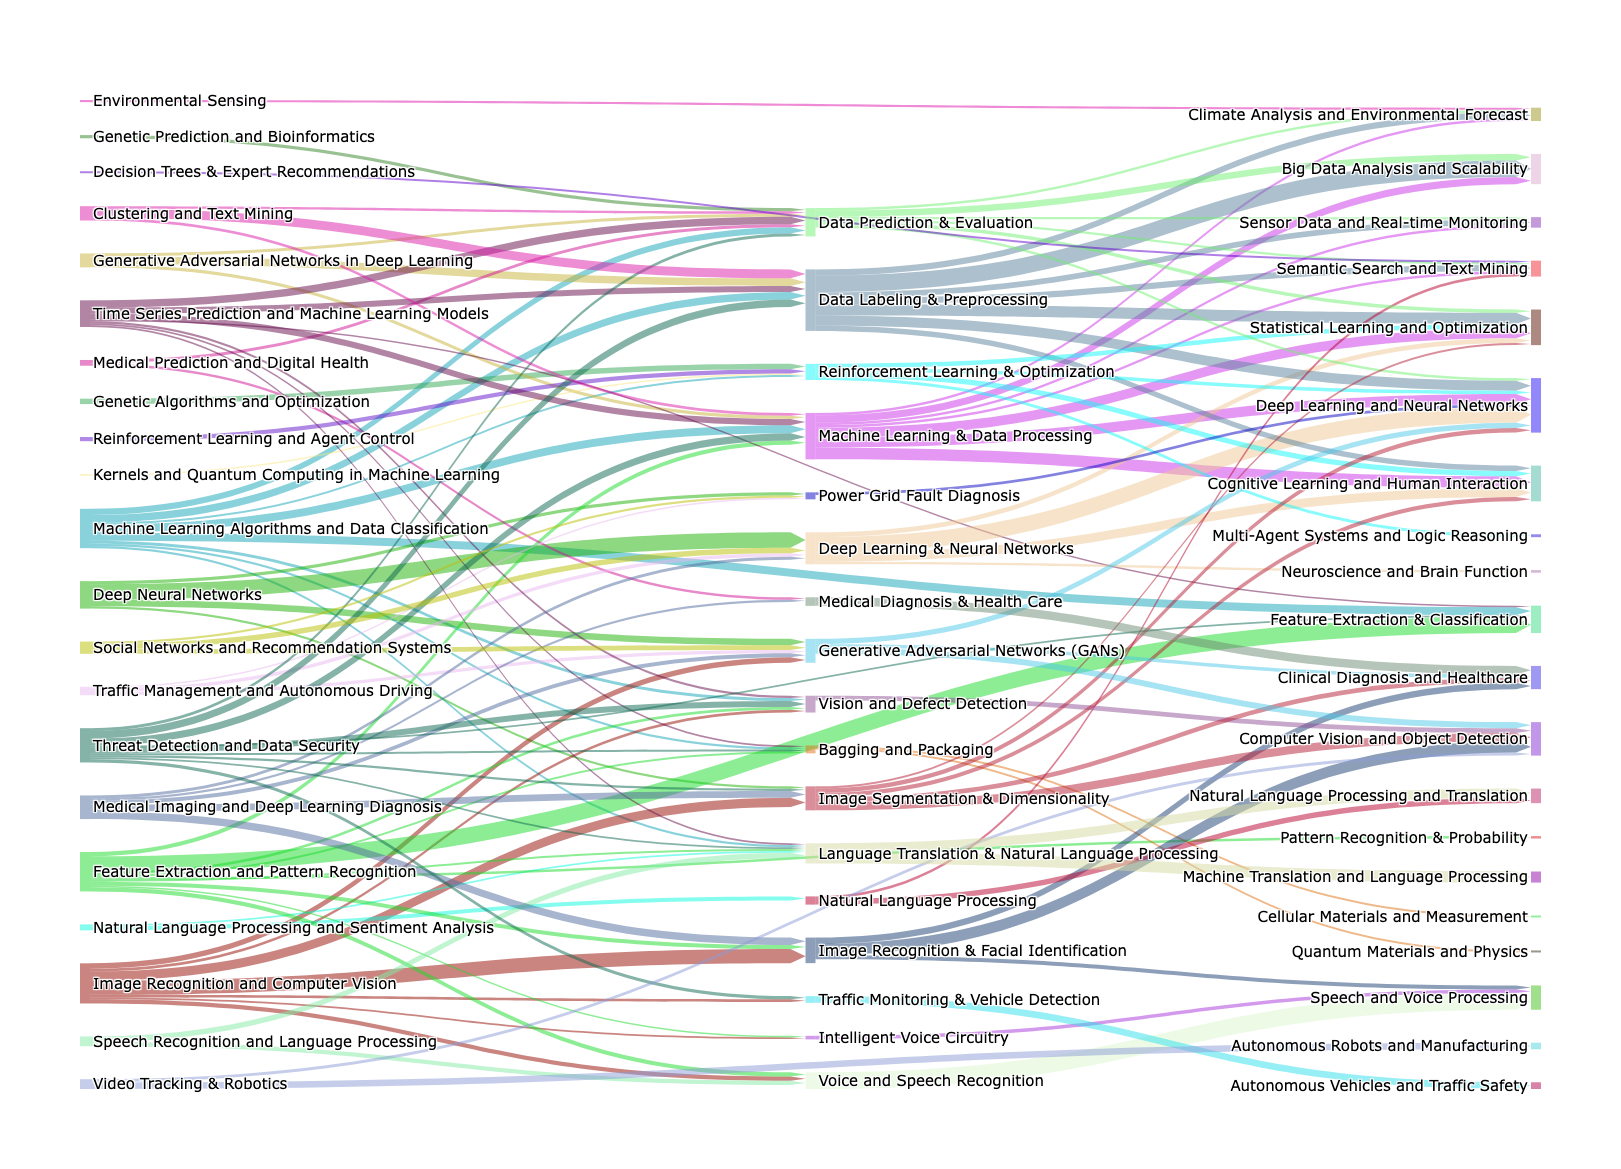

In [442]:
a = [el for el in range(oa_tpc)]
b = [el for el in range(pastat_tpc)]
combinations = list(itertools.product(a, b))

c = [el for el in range(pastat_tpc)]
d = [el for el in range(cordis_tpc)]
combinations2 = list(itertools.product(c, d))

df_f = pd.DataFrame(
    {"source": [i for i,_ in combinations],
     "target": [j+oa_tpc for _,j in combinations],
     "value": [sims[i,j] for i,j in combinations],
    }
)

df_f2 = pd.DataFrame(
    {"source": [i+oa_tpc for i,_ in combinations2],
     "target": [j+(oa_tpc+pastat_tpc) for _,j in combinations2],
     "value": [sims2[i,j] for i,j in combinations2],
    }
)   

df_f_labels = pd.DataFrame(
    {
        "id": df_f.source.unique().tolist() + df_f.target.unique().tolist(),
        "labels": df_oa.tpc_labels.values.tolist() + df_pastat.tpc_labels.values.tolist(),
        "hover":  df_oa.tpc_descriptions.values.tolist() + df_pastat.tpc_descriptions.values.tolist(),
    }
)
df_f_labels["color"] = [getRandRGB() for el in range(len(df_f_labels))]

df_f_labels2 = pd.DataFrame(
    {
        "id": df_f2.target.unique().tolist(),
        "labels": df_cordis.tpc_labels
        .values.tolist(),
        "hover": df_cordis.tpc_descriptions.values.tolist(),
    }
)
df_f_labels2["color"] = [getRandRGB() for el in range(len(df_f_labels2))]

def get_color(
    row,
    df:pd.DataFrame
) -> str:
    return df.iloc[row].color

df_f = pd.concat([df_f,df_f2])
df_f_labels = pd.concat([df_f_labels,df_f_labels2])
df_f["Link Color"] = df_f["source"].apply(lambda x: get_color(x, df_f_labels))

import plotly.graph_objects as go

fig = go.Figure(
    data=[go.Sankey(
        type='sankey',
        domain = dict(
            x =  [0,1],
            y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
        pad=300,
        thickness=10,
        line = dict(
            color = "black",
            width = 0
        ),
        label = df_f_labels["labels"].values.tolist(),
        color = df_f_labels["color"].values.tolist(),
        customdata = df_f_labels["hover"].values.tolist(),
        hovertemplate='%{customdata}\n\n', 
        ),
        link = dict(
          arrowlen=15,
          source = df_f["source"].values.tolist(),
          target = df_f["target"].values.tolist(),
          value = df_f["value"].values.tolist(),
          color = df_f['Link Color'],#.dropna(axis=0, how='any')
      ))],
    layout = dict(
        #title = "Sankey Diagram OA vs PASTAT vs CORDIS",
        width=16*100,
        height = 11.69*100,#1000
        font = dict(
            size = 15,
            color='rgba(0, 0, 0, 5)'))
)

fig.show()

In [446]:
#fig.update_layout(
#    width=595,  # Ancho en píxeles para A4 vertical (595 píxeles)
#    height=842,  # Altura en píxeles para A4 vertical (842 píxeles)
#    margin=dict(l=0, r=0, t=0, b=0),  # Configurar márgenes para ajustar al tamaño de A4
#)

# Guardar el gráfico como una imagen
import plotly.io as pio
#pio.write_image(fig, 'images/fig1.png')

pio.write_image(fig, 'images/sankey.png', width=16*100, height=11.69*100, scale=10)

In [447]:
import plotly.express as px

fig.write_html("images/sankey.html")